In [1]:
import time
from datetime import date, timedelta
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from scipy.optimize import curve_fit

In [2]:
#records = pd.read_csv('records.csv')
records = pd.read_csv('s+p_500_records.csv')
records.Date = records.Date.astype('datetime64')

In [3]:
records = records.loc[records.Date.isin(records.Date.value_counts()[records.Date.value_counts() == records.Date.value_counts().max()].index)]

In [4]:
records.Date.value_counts()

2021-04-09    487
2019-01-07    487
2017-05-31    487
2019-10-08    487
2018-02-22    487
             ... 
2019-05-28    487
2020-07-31    487
2018-11-20    487
2020-01-24    487
2018-07-17    487
Name: Date, Length: 1258, dtype: int64

In [5]:
stocks = records.Symbol.unique()

In [28]:
def linear(x,a,b):
    return a*x + b

In [6]:
def quadratic(x,a,b,c):
    return a*x**2 + b*x + c

In [7]:
def get_r_squared(Stock):
    t = np.array([(d - datetime(1970,1,1)).days for d in Stock.Date])
    y = Stock['Closing Price'].to_numpy()
    popt, pcov = curve_fit(quadratic, t, y)
    fit = quadratic(t,*popt)
    residuals = y - fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [8]:
def stock_score_data(df, stock, start, stop):
    StockDF = df.loc[(df.Symbol == stock) & (df.Date >= start) & (df.Date < stop)]
    growth = StockDF['Closing Price'].iloc[-1] / StockDF['Closing Price'].iloc[0]
    smoothness = get_r_squared_lin(StockDF)
    #smoothness = get_r_squared(StockDF)
    
    return (smoothness, growth)
    

In [9]:
def get_r_squares(df,start,stop):
    m = len(df.Symbol.unique())
    
    rec_slice = df.loc[(df.Date >= start) & (df.Date < stop)]
    
    n = len(rec_slice) // m
    
    y = np.transpose(rec_slice['Closing Price'].values.reshape((m,n)))
    
    x = [n*[1]]
    x.append(list(range(n)))
    x = np.transpose(np.array(x))

    b = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T,x)),x.T),y)

    fits = np.matmul(x,b)

    residuals = y - fits

    ss_res = np.sum(residuals**2,axis=0)
    ss_tot = np.sum((y - np.mean(y,axis=0))**2,axis=0)

    ss_res[ss_tot == 0] = 1.0
    ss_tot[ss_tot == 0] = 1.0
    
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared

In [10]:
def get_growths(df, start, end):
    return df.loc[df.Date == end]['Closing Price'].values / df.loc[df.Date == start]['Closing Price'].values

In [11]:
def get_price(df, stock, date):
    while date not in df.Date.values:
        date += pd.Timedelta(1,'d')
    return df.loc[(df.Date == date) & (df.Symbol == stock)]['Closing Price'].iloc[0]

In [12]:
def get_prices(df,date):
    while date not in df.Date.values:
        date += pd.Timedelta(1,'d')
    return df.loc[df.Date == date]['Closing Price'].values

In [68]:
period = pd.Timedelta(24,'w')
hist_per = pd.Timedelta(24,'w')

#date = records.Date.max() - pd.Timedelta(104,'w')
date = records.Date.min() + hist_per
max_date = records.Date.max()
prev = {}

cash = 1000
fee = 10.0
num = 3

graph = False

while date <= max_date:
    start_prices = get_prices(records, date - hist_per)
    end_prices = get_prices(records, date)
    growths = (end_prices - start_prices ) / start_prices

    smoothness = get_r_squares(records, date - hist_per, date)
    prices = dict(list(zip(records.Symbol.unique(),end_prices)))
    
    ratings = list(zip(records.Symbol.unique(),growths,smoothness))
    ratings.sort(key = lambda x: x[1]*x[2]**10,reverse=True)
        
    top = [x[0] for x in ratings[:num]]
    holding = {}
    
    new = [s for s in top if s not in prev.keys()]
    hold = [s for s in top if s in prev.keys()]
    #hold = [s for s in prev.keys() if get_price(records, s, date) > get_price(records,s,date - period)]
    sell = [s for s in prev.keys() if s not in top]
    
    #if len(new) + len(hold)
    for s in sell:
        cash += prev[s]*prices[s] - fee
    for h in hold:
        holding[h] = prev[h]
    for i in range(len(new)):
        amt = cash/(len(new) - i) - fee
        qnt = amt // prices[new[i]]
        if qnt < 1:
            continue
        holding[new[i]] = qnt
        cash -= (qnt*prices[new[i]] + fee)
        #print(cash)
    
    print('On',(date).date(),'\n\t\tBuy: ',', '.join(new))
    print('\t\tHold:',', '.join(hold))
    print('\t\tSell:',', '.join(sell))
    
    print(holding)
    assets = sum([holding[x]*prices[x] for x in holding.keys()])
    print('Assets:',assets)
    print('Cash:',cash)
    print('Net:',assets+cash)
    
    
    if graph:
        for s in top:
            plot_stock_lin(records,s,date - hist_per,date)
            plot_stock_lin(records,s,date,date+period)
            plt.show()
    
    
    prev = holding
    date += period




On 2017-01-02 
		Buy:  PFG, CFG, NVDA
		Hold: 
		Sell: 
{'PFG': 5.0, 'CFG': 9.0, 'NVDA': 3.0}
Assets: 921.6700000000001
Cash: 48.329999999999984
Net: 970.0
On 2017-06-19 
		Buy:  ATVI, WYNN, NVR
		Hold: 
		Sell: PFG, CFG, NVDA
{'ATVI': 6.0, 'WYNN': 2.0}
Assets: 638.76
Cash: 489.8799999999998
Net: 1128.6399999999999
On 2017-12-04 
		Buy:  DLTR, CBOE, TDY
		Hold: 
		Sell: ATVI, WYNN
{'DLTR': 3.0, 'CBOE': 3.0, 'TDY': 2.0}
Assets: 1052.28
Cash: 55.33999999999992
Net: 1107.62
On 2018-05-21 
		Buy:  ABMD, FTNT, ADBE
		Hold: 
		Sell: DLTR, CBOE, TDY
{'FTNT': 8.0, 'ADBE': 2.0}
Assets: 950.76
Cash: 55.06999999999999
Net: 1005.8299999999999
On 2018-11-05 
		Buy:  MKC, LLY, MRK
		Hold: 
		Sell: FTNT, ADBE
{'MKC': 4.0, 'LLY': 3.0, 'MRK': 6.0}
Assets: 1062.8400000000001
Cash: 20.969999999999857
Net: 1083.81
On 2019-04-22 
		Buy:  KEYS, ENPH, XLNX
		Hold: 
		Sell: MKC, LLY, MRK
{'KEYS': 3.0, 'ENPH': 42.0, 'XLNX': 2.0}
Assets: 930.41
Cash: 123.06999999999982
Net: 1053.4799999999998
On 2019-10-07 
		B

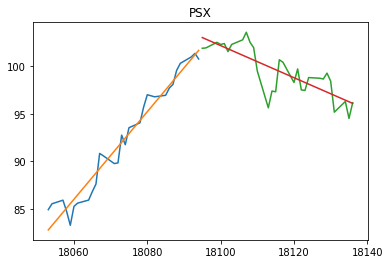

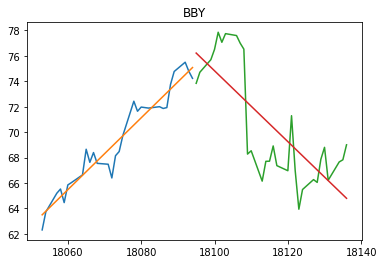

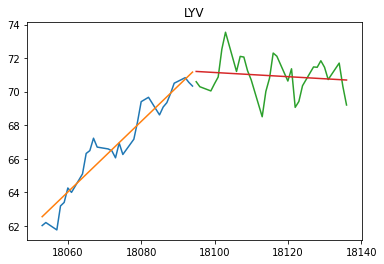

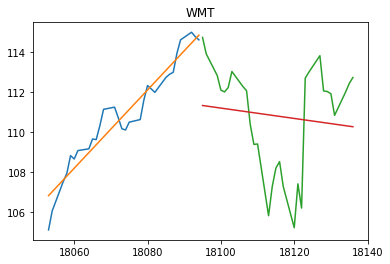

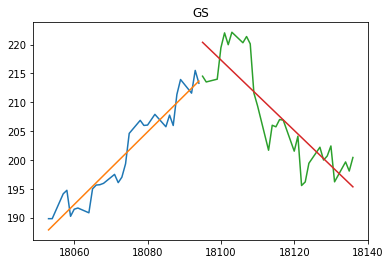

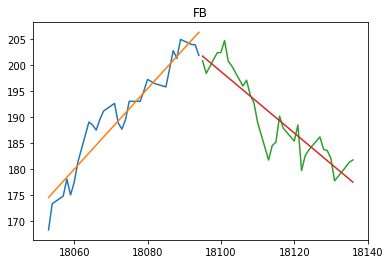

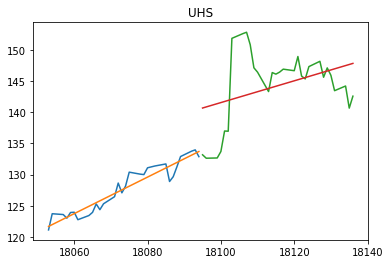

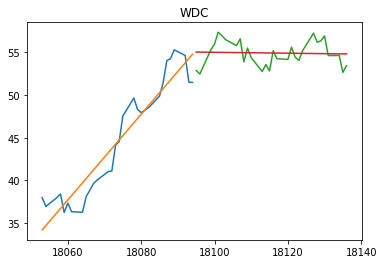

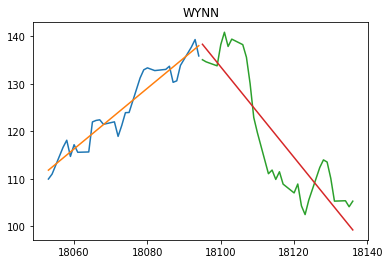

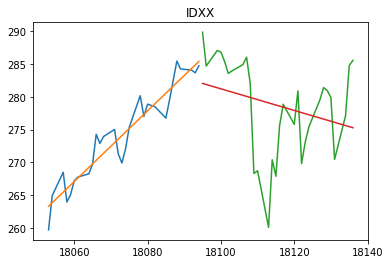

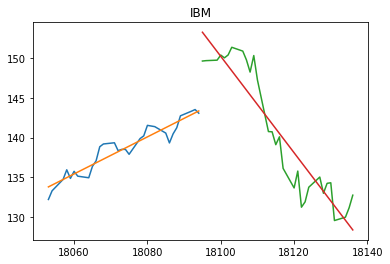

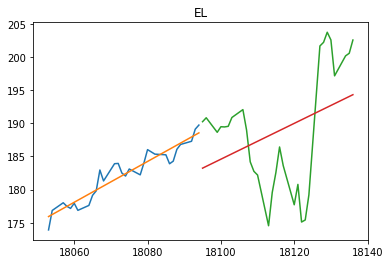

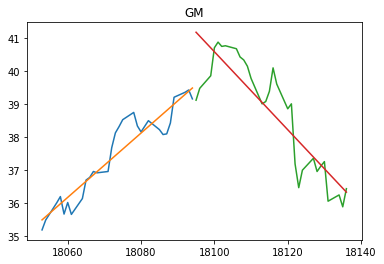

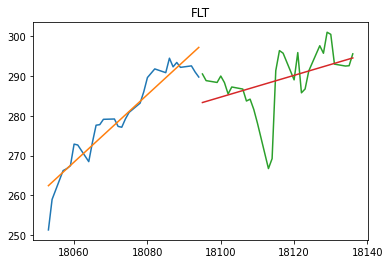

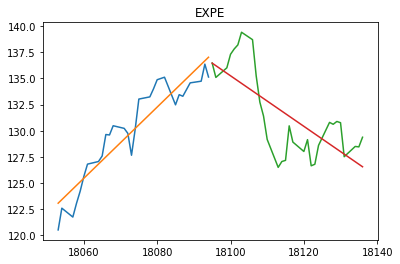

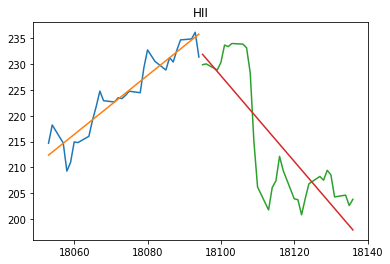

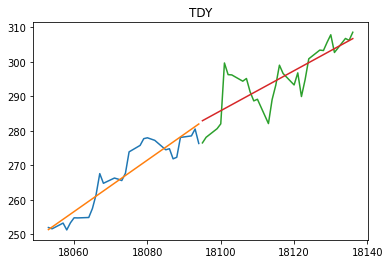

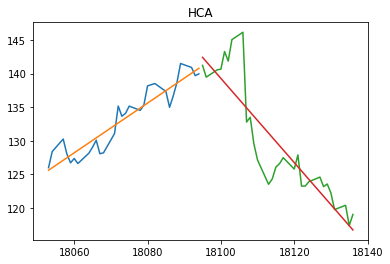

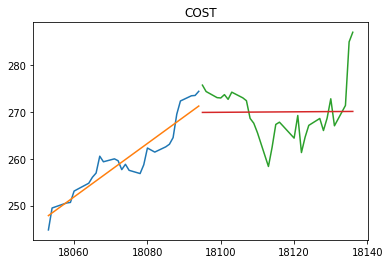

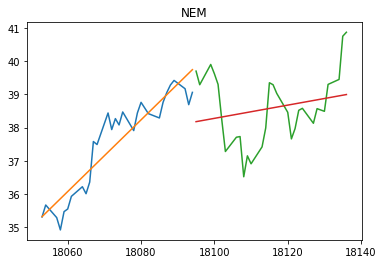

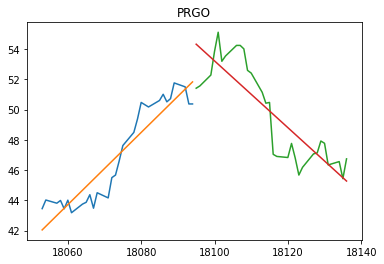

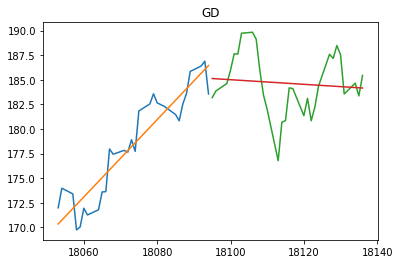

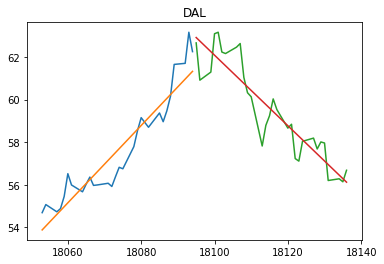

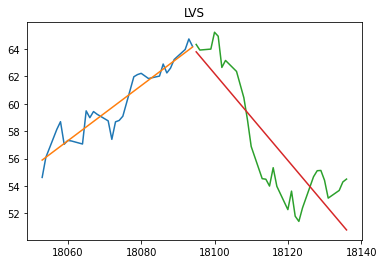

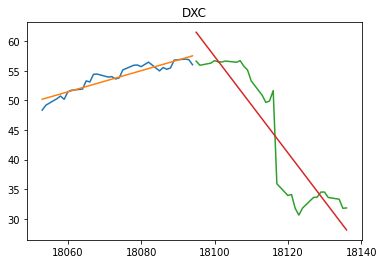

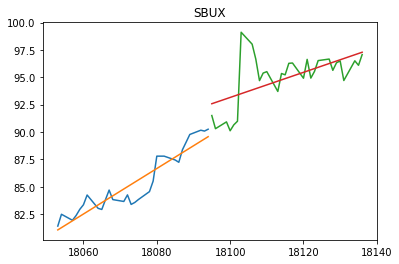

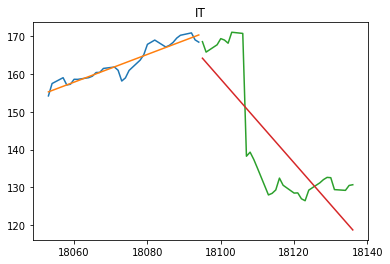

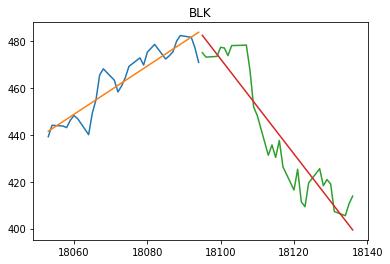

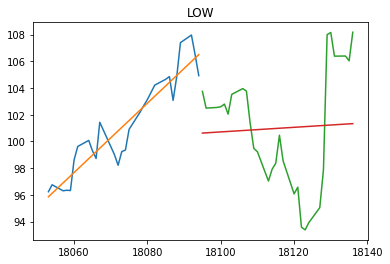

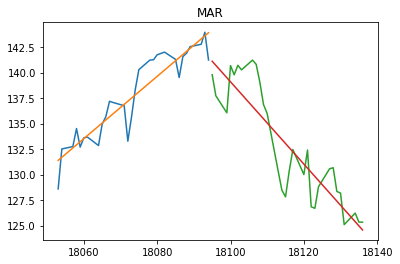

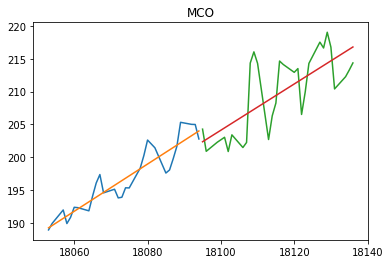

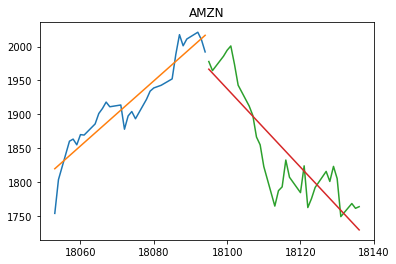

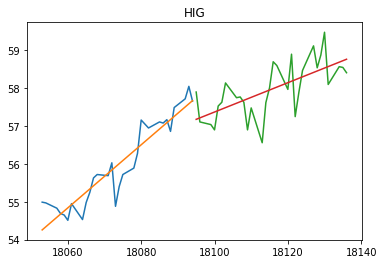

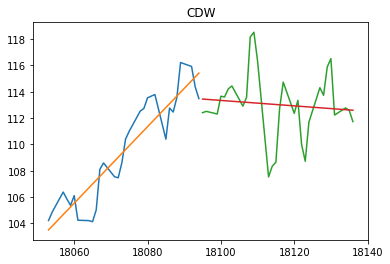

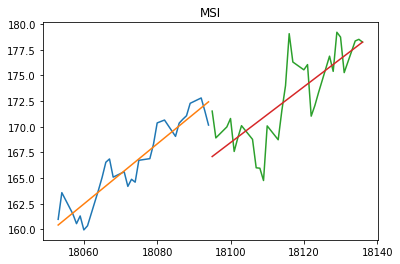

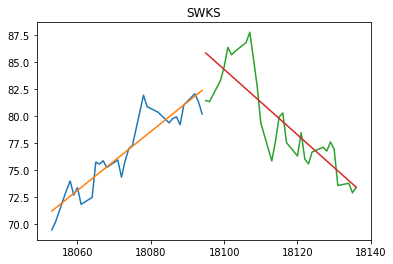

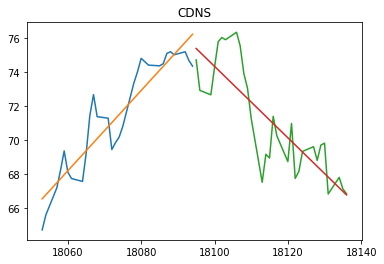

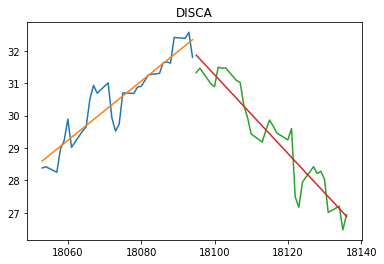

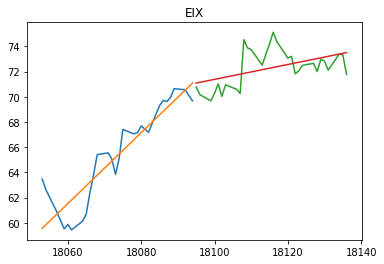

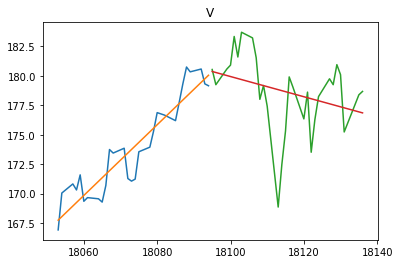

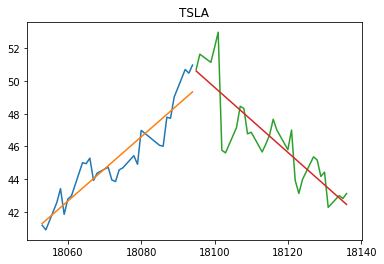

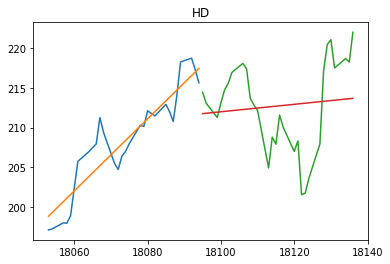

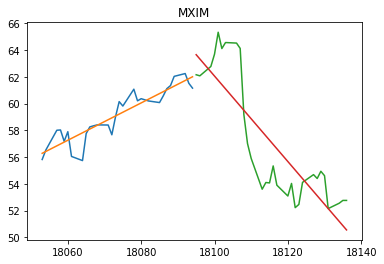

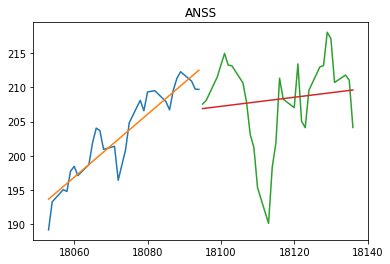

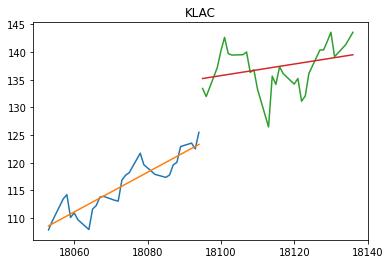

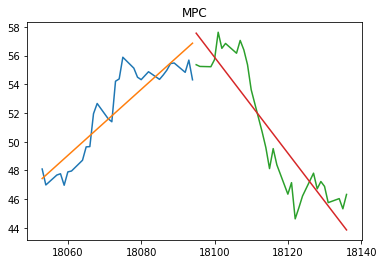

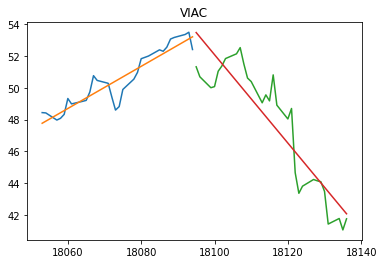

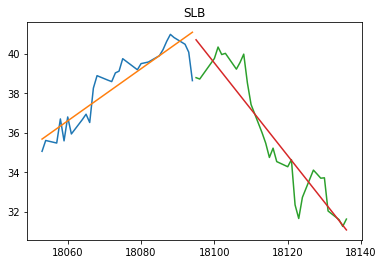

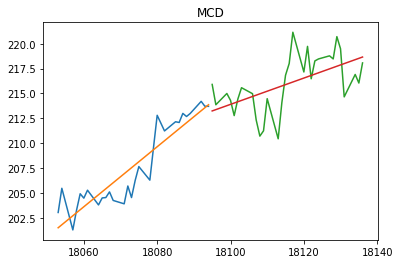

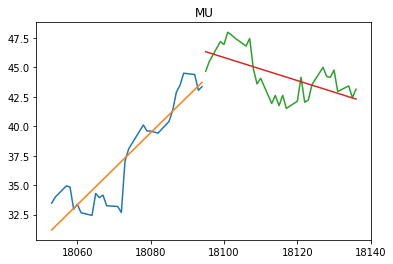

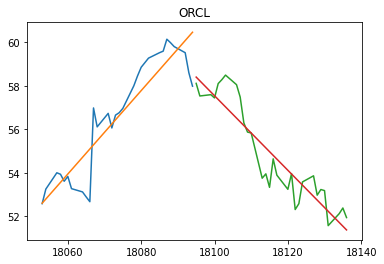

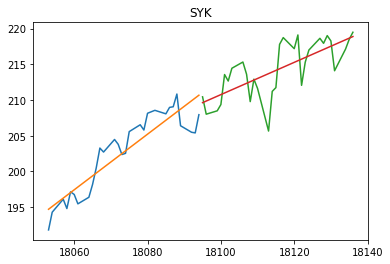

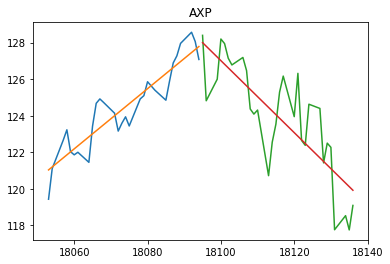

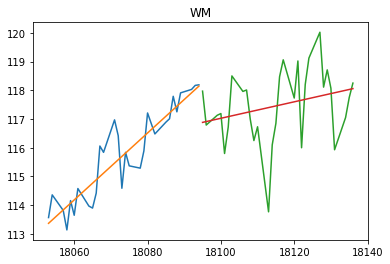

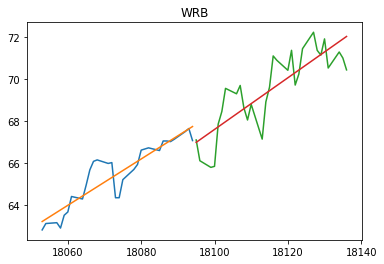

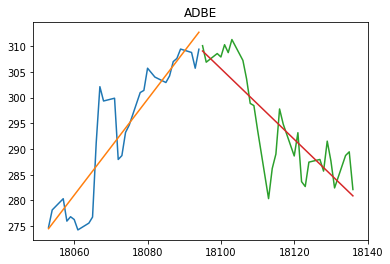

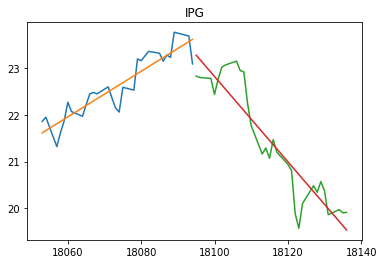

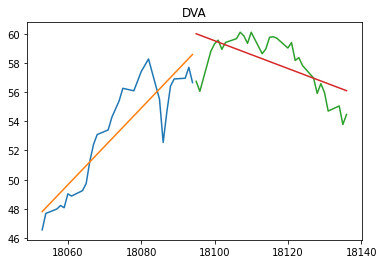

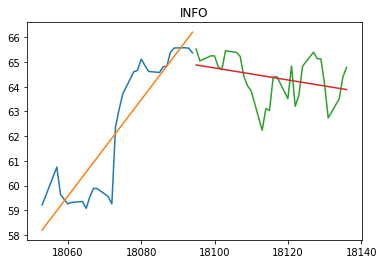

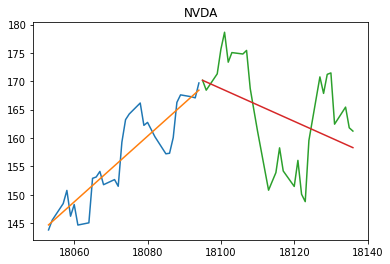

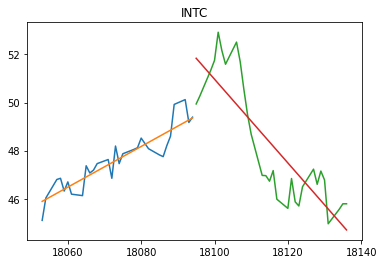

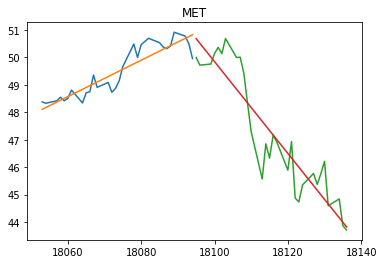

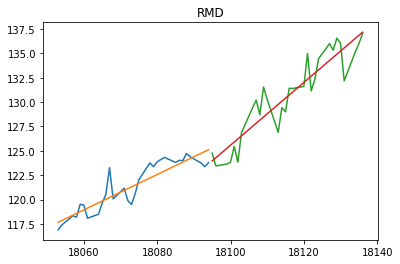

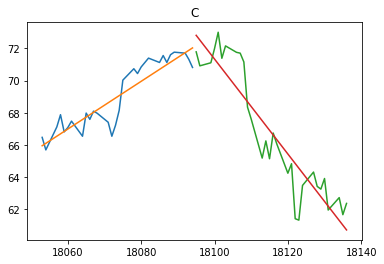

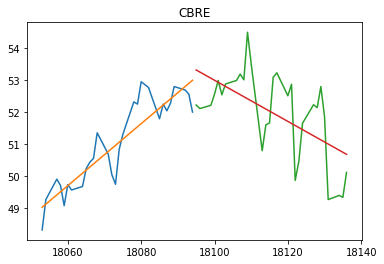

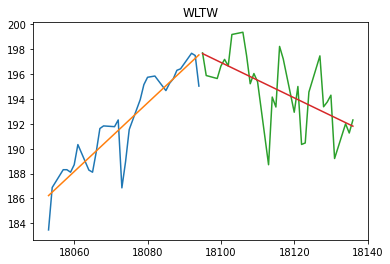

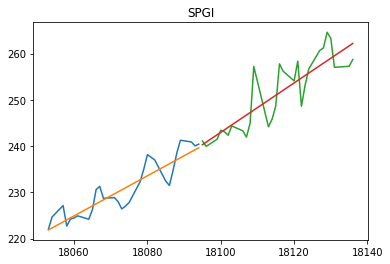

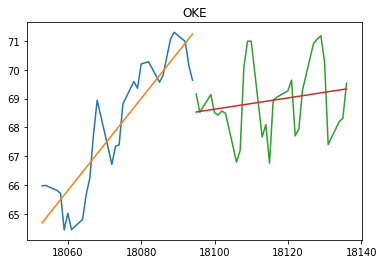

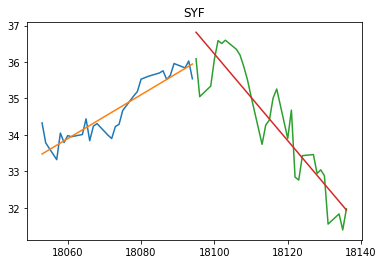

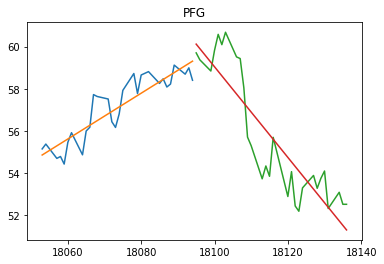

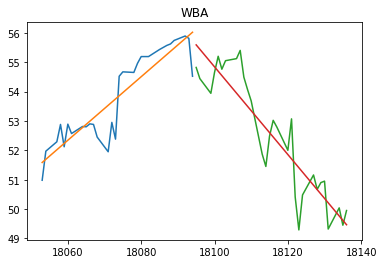

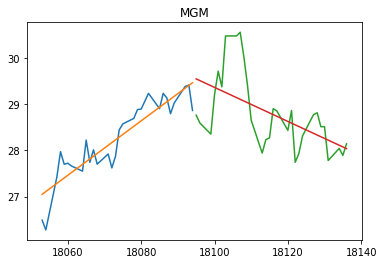

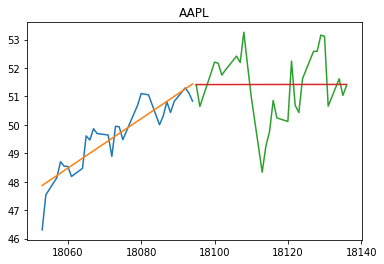

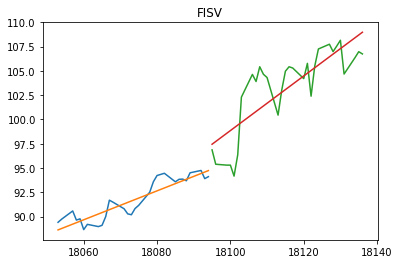

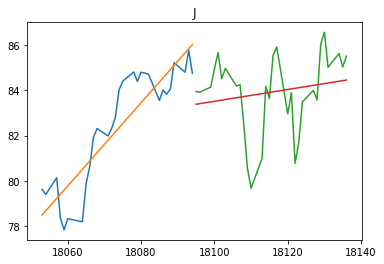

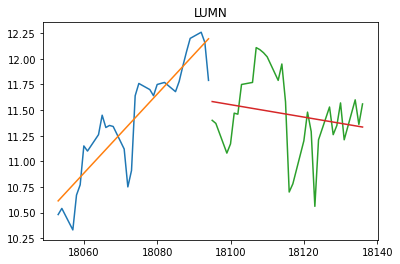

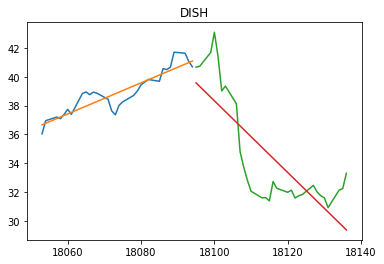

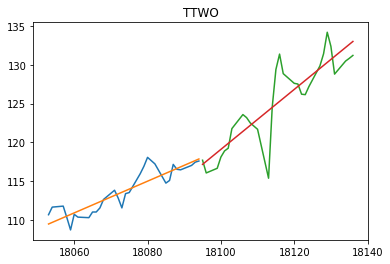

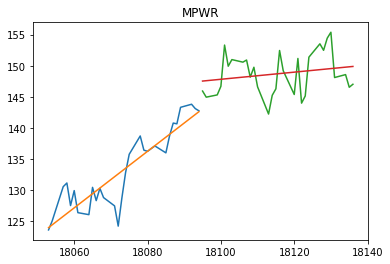

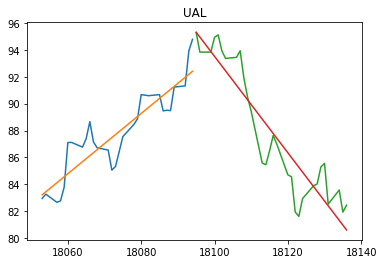

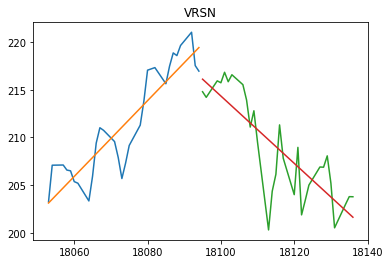

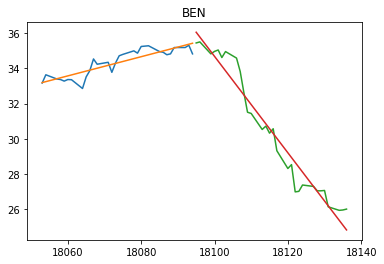

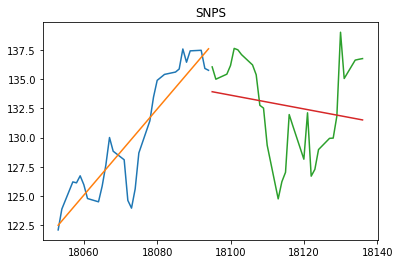

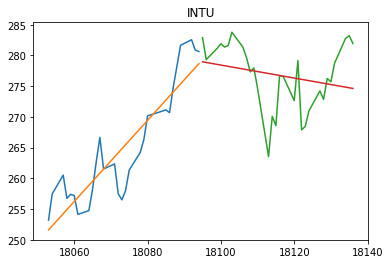

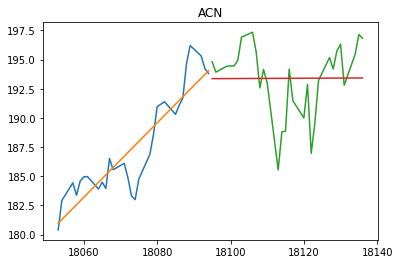

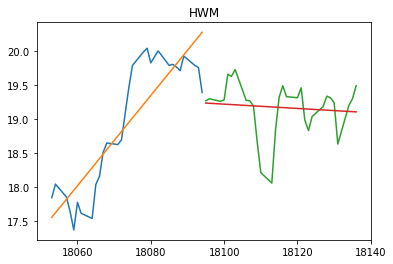

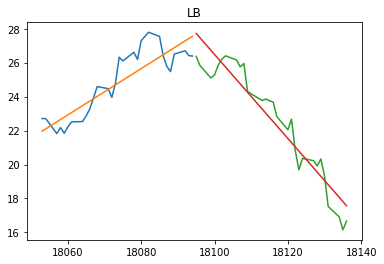

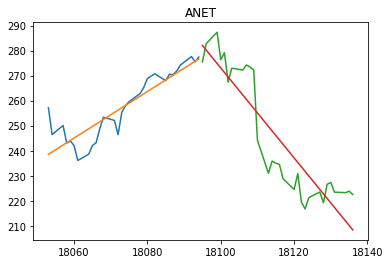

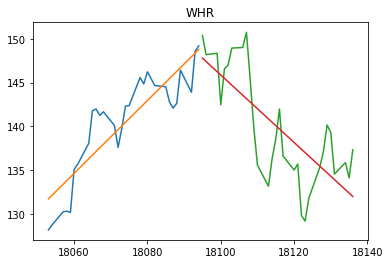

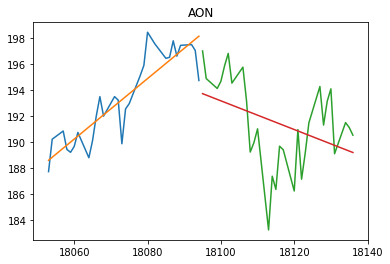

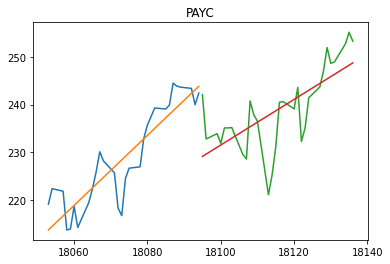

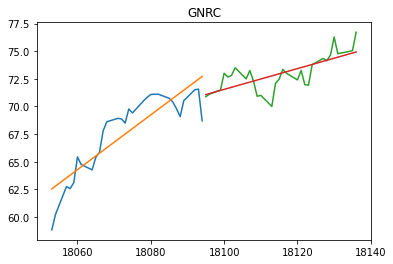

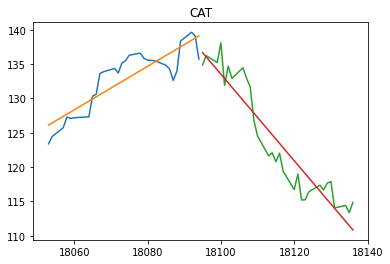

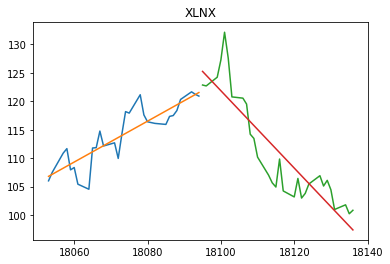

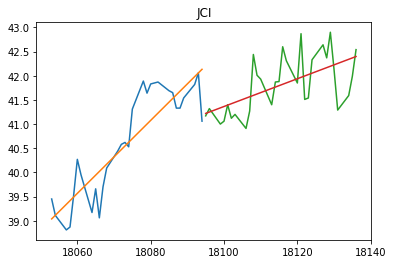

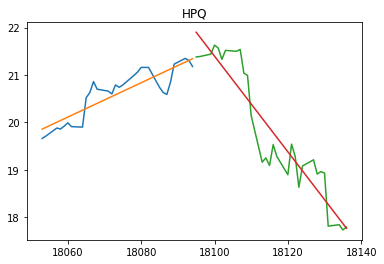

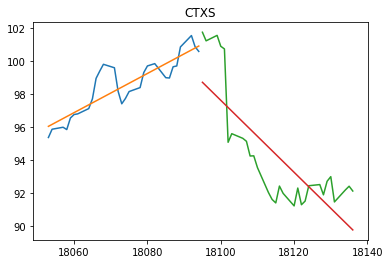

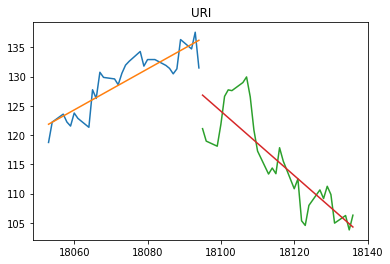

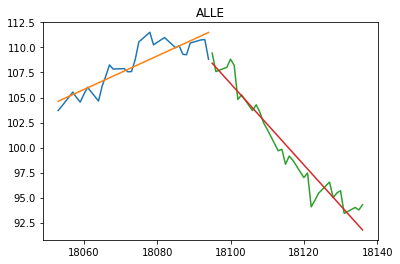

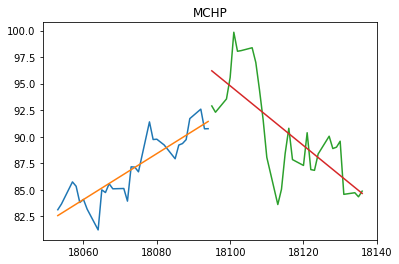

In [29]:
for s in ratings[:100]:
    plot_stock_lin(records,s[0],date - hist_per,date)
    plot_stock_lin(records,s[0],date,date+period)
    plt.show()

In [19]:
def get_growth(df, stocks, period):
    growths = np.zeros(len(stocks))
    
    StockDF = df.loc[(df.Symbol == stock) & (df.Date >= (pd.Timestamp('today') - pd.Timedelta(period,'d')))]
    growth = StockDF['Closing Price'].iloc[-1] / StockDF['Closing Price'].iloc[0]
    
    return (smoothness, growth)

In [20]:
#%timeit -n2 stock_score_data(records, 'MSFT', 90)
max = 5*365
for i in range(max):
    print(len(records.loc[records.Date == (pd.Timestamp('today') - pd.Timedelta(i,'d')).normalize()]))


487
487
487
487
0
0
487
487
487
487
0
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
0
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
0
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
0
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
0
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
0
487
487
487
487
0
0
0
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
0
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487
487
487
0
0
487
487
487


In [21]:
len(records.Date.unique()) / 90

13.977777777777778

In [22]:
def plot_stock(df, stock, start, stop):
    StockDF = df.loc[(df.Symbol == stock) & (df.Date >= start) & (df.Date < stop)]
    t = np.array([(d - datetime(1970,1,1)).days for d in StockDF.Date])
    y = StockDF['Closing Price'].to_numpy()
    popt, pcov = curve_fit(quadratic, t, y)
    fit = quadratic(t,*popt)
    plt.plot(t,y)
    plt.plot(t,fit)
    plt.title(stock)
    #plt.show()

In [23]:
def plot_stock_lin(df, stock, start, stop):
    StockDF = df.loc[(df.Symbol == stock) & (df.Date >= start) & (df.Date < stop)]
    t = np.array([(d - datetime(1970,1,1)).days for d in StockDF.Date])
    y = StockDF['Closing Price'].to_numpy()
    popt, pcov = curve_fit(linear, t, y)
    fit = linear(t,*popt)
    plt.plot(t,y)
    plt.plot(t,fit)
    plt.title(stock)
    #plt.show()

In [26]:
scores = []
for i in range(len(stocks)):
    print(i,'/',len(stocks))
    scores.append(stock_score_data(records, stocks[i], records.Date.max() - pd.Timedelta(360,'d'),records.Date.max() - pd.Timedelta(180,'d')))

0 / 487


NameError: name 'get_r_squared_lin' is not defined

In [25]:
r_sq = [s[0] for s in scores]
growth = [g[1] for g in scores]
rankings = list(zip(stocks, r_sq,growth))
rankings.sort(key = lambda x: x[2]*x[1]**1000,reverse=True)

srt = 0
sz = 10

ps0 = records.Date.max() - pd.Timedelta(360,'d')
pe0 = records.Date.max() - pd.Timedelta(180,'d')

p_start = records.Date.max() - pd.Timedelta(180,'d')
p_end = records.Date.max() - pd.Timedelta(0,'d')

for stock,sq,g in rankings[srt:srt+sz]:
    plot_stock_lin(records,stock,ps0,pe0)
    plot_stock_lin(records,stock,p_start,p_end)
    plt.show()